# Experiment 07 Analysis: Bayesian Optimization Representation Size Comparison

This notebook analyzes the results of Experiment 07, which systematically compares three molecular representation methods (random baseline, Morgan fingerprints, HDC) across varying embedding sizes for Bayesian Optimization-based molecular search.

**Key Research Questions:**
1. How does representation dimensionality affect BO convergence speed?
2. Which representation method achieves best performance at minimal embedding size?
3. How much better are structured representations (FP, HDC) compared to random baseline?
4. At what embedding size do we see diminishing returns for each method?

**Primary Metric:** Area Under Curve (AUC) - lower values indicate faster convergence to target property values.

In [1]:
%matplotlib inline
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')

## Experiment Selection and Sorting Functions

Define how to filter and group experiments based on their parameters.

In [2]:
# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict
                      ) -> bool:
    """Select only Experiment 07 BO experiments."""
    main_condition = 'ex_07_c' in experiment_parameters.get('__PREFIX__', '')
    return main_condition


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    """Sort experiments by (encoding, embedding_size)."""
    
    # Determine encoding type from experiment name
    experiment_name = experiment.metadata['name']
    if '__random' in experiment_name:
        encoding = 'random'
    elif '__fp' in experiment_name:
        encoding = 'fp'
    elif '__hdc' in experiment_name:
        encoding = 'hdc'
    else:
        encoding = 'unknown'
    
    # Extract embedding size based on encoding type
    if encoding == 'random':
        embedding_size = experiment.parameters.get('RANDOM_DIM', 0)
    elif encoding == 'fp':
        embedding_size = experiment.parameters.get('FINGERPRINT_SIZE', 0)
    elif encoding == 'hdc':
        embedding_size = experiment.parameters.get('EMBEDDING_SIZE', 0)
    else:
        embedding_size = 0
    
    return (encoding, embedding_size)

## Experiment Discovery

Find all archived experiments in the results directory.

In [3]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 37406 experiment archives in 82 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +37403
]

## Experiment Loading

Load only the experiments that match our selection criteria (Experiment 07).

In [4]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Apply filter to determine whether experiment should be included
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   > included experiment "ex_07_c__28_11_2025__15_55__L6dQ"
   > included experiment "ex_07_c__28_11_2025__17_37__AJvb"
   > included experiment "ex_07_c__28_11_2025__19_54__KBWE"
   > included experiment "ex_07_c__28_11_2025__21_05__tFJO"
   > included experiment "ex_07_c__28_11_2025__16_44__oKgB"
   > included experiment "ex_07_c__28_11_2025__19_15__EBkM"
   > included experiment "ex_07_c__28_11_2025__19_37__zIIo"
   > included experiment "ex_07_c__28_11_2025__17_24__xk9f"
   > included experiment "ex_07_c__28_11_2025__18_29__VXA7"
   > included experiment "ex_07_c__28_11_2025__17_14__JkFK"
   > included experiment "ex_07_c__28_11_2025__20_59__m6Vm"
   > included experiment "ex_07_c__28_11_2025__20_10__V15k"
   > included experiment "ex_07_c__28_11_2025__19_00__naYz"
✅ Loaded 13 experiments in 9.89 seconds


In [5]:
# Inspect example experiment data structure
if experiments:
    example_experiment: Experiment = experiments[0]
    print("\nExample experiment data structure:")
    print(f"Name: {example_experiment.metadata['name']}")
    print(f"\nParameters (sample):")
    for key in ['SEED', 'NUM_TRIALS', 'NUM_BO_ROUNDS', 'NUM_INITIAL_SAMPLES']:
        if key in example_experiment.parameters:
            print(f"  {key}: {example_experiment.parameters[key]}")
    print(f"\nData keys:")
    pprint(list(example_experiment.data.keys()), max_length=10)
    print(f"\nMetrics keys (if available):")
    if 'metrics' in example_experiment.data:
        metric_keys = list(example_experiment.data['metrics'].keys())
        pprint(metric_keys, max_length=20)
        
        # Check if per-trial data exists
        print(f"\n✓ Checking for per-trial metrics:")
        if 'auc_per_trial' in example_experiment.data['metrics']:
            auc_per_trial = example_experiment.data['metrics']['auc_per_trial']
            print(f"  ✅ auc_per_trial found: {len(auc_per_trial)} trials")
            print(f"     Sample values: {auc_per_trial[:3]}")
        else:
            print(f"  ⚠️  auc_per_trial NOT FOUND - will only have mean values")
            print(f"     Available: {[k for k in metric_keys if 'auc' in k]}")
    else:
        print("  ⚠️  No metrics found in experiment data!")


Example experiment data structure:
Name: optimize_molecule_bo__fp

Parameters (sample):
  SEED: 1
  NUM_TRIALS: 25
  NUM_BO_ROUNDS: 25
  NUM_INITIAL_SAMPLES: 10

Data keys:


['indices', 'correlation', 'optimization', 'summary', 'metrics']


Metrics keys (if available):


[
│   'auc_mean',
│   'auc_std',
│   'auc_min',
│   'auc_max',
│   'auc_per_trial',
│   'simple_regret_mean',
│   'simple_regret_std',
│   'simple_regret_min',
│   'simple_regret_max',
│   'simple_regret_per_trial',
│   'rounds_to_threshold_mean',
│   'rounds_to_threshold_std',
│   'rounds_to_threshold_min',
│   'rounds_to_threshold_max',
│   'rounds_to_threshold_per_trial',
│   'initial_value_mean',
│   'initial_value_std',
│   'initial_value_min',
│   'initial_value_max',
│   'initial_value_per_trial',
│   ... +10
]


✓ Checking for per-trial metrics:
  ✅ auc_per_trial found: 25 trials
     Sample values: [4.04287201911211, 3.7248507365584373, 2.393788166344166]


## Experiment Sorting

Group experiments by encoding method and embedding size.

In [6]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
# Sort by encoding name and then by embedding size
key_experiment_map = dict(sorted(
    key_experiment_map.items(), 
    key=lambda item: (item[0][0], item[0][1])  # (encoding, size)
))
    
print(f"\n✅ Grouped experiments into {len(key_experiment_map)} unique configurations")
print("\nConfigurations found:")
for (encoding, size), exps in key_experiment_map.items():
    print(f"  {encoding:8s} | size={size:5d} | n_experiments={len(exps)}")


✅ Grouped experiments into 13 unique configurations

Configurations found:
  fp       | size=    8 | n_experiments=1
  fp       | size=   16 | n_experiments=1
  fp       | size=   32 | n_experiments=1
  fp       | size=   64 | n_experiments=1
  fp       | size=  128 | n_experiments=1
  hdc      | size=    8 | n_experiments=1
  hdc      | size=   16 | n_experiments=1
  hdc      | size=   32 | n_experiments=1
  random   | size=    8 | n_experiments=1
  random   | size=   16 | n_experiments=1
  random   | size=   32 | n_experiments=1
  random   | size=   64 | n_experiments=1
  random   | size=  128 | n_experiments=1


## Extract Comparison Metrics

Extract AUC (Area Under Curve) and other comparison metrics from each experiment.

In [7]:
from prettytable import PrettyTable

# Create summary table
table = PrettyTable()
table.field_names = ['Encoding', 'Emb. Size', 'AUC', 'Simple Regret', 'Rounds to Threshold', 'Improvement %']

# Collect metrics for each configuration
metrics_data = {}

for (encoding, emb_size), _experiments in key_experiment_map.items():
    
    # Extract per-trial metrics (each experiment runs NUM_TRIALS=25 independent BO trials)
    # We collect ALL trial values across all experiments for this configuration
    auc_values = []
    regret_values = []
    rounds_values = []
    improvement_values = []
    
    for exp in _experiments:
        if 'metrics' in exp.data:
            metrics = exp.data['metrics']
            
            # Extract per-trial AUC values (each experiment has 25 trials)
            # This gives us the full distribution of AUC values for box plots
            if 'auc_per_trial' in metrics:
                # Extend the list with all per-trial values (not just mean!)
                auc_values.extend(metrics['auc_per_trial'])
            
            # Extract per-trial simple regret values
            if 'simple_regret_per_trial' in metrics:
                regret_values.extend(metrics['simple_regret_per_trial'])
            
            # Extract per-trial rounds to threshold
            if 'rounds_to_threshold_per_trial' in metrics:
                rounds_values.extend(metrics['rounds_to_threshold_per_trial'])
            
            # Extract per-trial improvement percentage
            if 'improvement_pct_per_trial' in metrics:
                improvement_values.extend(metrics['improvement_pct_per_trial'])
    
    # Store all per-trial metrics
    metrics_data[(encoding, emb_size)] = {
        'auc': auc_values,
        'regret': regret_values,
        'rounds': rounds_values,
        'improvement': improvement_values,
    }
    
    # Add row to summary table
    if auc_values:
        auc_mean = np.mean(auc_values)
        auc_std = np.std(auc_values) if len(auc_values) > 1 else 0
        
        regret_str = f"{np.mean(regret_values):.3f} ± {np.std(regret_values):.3f}" if regret_values else "N/A"
        rounds_str = f"{np.mean(rounds_values):.1f} ± {np.std(rounds_values):.1f}" if rounds_values else "N/A"
        improv_str = f"{np.mean(improvement_values):.1f}% ± {np.std(improvement_values):.1f}%" if improvement_values else "N/A"
        
        table.add_row([
            encoding,
            emb_size,
            f'{auc_mean:.2f} ± {auc_std:.2f} (n={len(auc_values)})',
            regret_str,
            rounds_str,
            improv_str,
        ])

print("\n" + "="*80)
print("BAYESIAN OPTIMIZATION COMPARISON METRICS")
print("="*80)
print("\nLower AUC = Faster convergence (PRIMARY METRIC)")
print(f"Note: Each configuration shows mean ± std across all per-trial values")
print(f"      (typically 25 trials per experiment × number of experiments)")
print(table.get_string())


BAYESIAN OPTIMIZATION COMPARISON METRICS

Lower AUC = Faster convergence (PRIMARY METRIC)
Note: Each configuration shows mean ± std across all per-trial values
      (typically 25 trials per experiment × number of experiments)
+----------+-----------+--------------------+---------------+---------------------+---------------+
| Encoding | Emb. Size |        AUC         | Simple Regret | Rounds to Threshold | Improvement % |
+----------+-----------+--------------------+---------------+---------------------+---------------+
|    fp    |     8     | 3.47 ± 0.51 (n=25) | 0.069 ± 0.024 |      0.0 ± 0.0      | 74.5% ± 10.7% |
|    fp    |     16    | 3.89 ± 1.05 (n=25) | 0.077 ± 0.043 |      0.0 ± 0.0      | 69.9% ± 23.1% |
|    fp    |     32    | 3.48 ± 1.31 (n=25) | 0.081 ± 0.060 |      0.0 ± 0.0      | 70.9% ± 25.0% |
|    fp    |     64    | 4.42 ± 1.91 (n=25) | 0.117 ± 0.084 |      0.0 ± 0.0      | 61.3% ± 25.8% |
|    fp    |    128    | 3.44 ± 0.40 (n=25) | 0.062 ± 0.000 |      0.0 ±

## Verify Data Collection for Box Plots

Check that we have enough per-trial values for meaningful box plots.

In [8]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Embedding sizes to visualize (should match sweep in _slurm_ex_07.py)
EMBEDDING_SIZES = [8, 16, 32, 64, 128]

# Figure size (width, height) in inches
FIGSIZE = (12, 6)

# Font size
FONT_SIZE = 11

# Color scheme (matching other experiment analyses)
COLORS = {
    'random': '#808080',   # Gray for random baseline
    'fp': '#7C92FF',       # Blue for fingerprints (matching analyze_ex_03)
    'hdc': '#69F7AE',      # Green for HDC (matching analyze_ex_03)
}

# Labels for legend
LABELS = {
    'random': 'Random Baseline',
    'fp': 'Morgan FP (ECFP4)',
    'hdc': 'HDC (2-layer)',
}


# ============================================================================
# PLOT SETUP
# ============================================================================

plt.style.use('default')
plt.rcParams['font.family'] = 'Roboto Condensed'
plt.rcParams['font.size'] = FONT_SIZE

fig, ax = plt.subplots(figsize=FIGSIZE)


# ============================================================================
# DATA PREPARATION FOR BOX PLOTS
# ============================================================================

# Organize data for box plots
# We want to create box plots at each embedding size, with three boxes side-by-side
# for random, fp, and hdc

encodings = ['random', 'fp', 'hdc']
box_width = 0.25  # Width of each box
positions_offset = [-box_width, 0, box_width]  # Offsets for side-by-side boxes

# Store median values for trend lines
median_data = {encoding: {'positions': [], 'medians': []} for encoding in encodings}

# For each embedding size, create box plots for each encoding
for size_idx, emb_size in enumerate(EMBEDDING_SIZES):
    
    for enc_idx, encoding in enumerate(encodings):
        key = (encoding, emb_size)
        
        if key in metrics_data and metrics_data[key]['auc']:
            auc_values = metrics_data[key]['auc']
            
            # Calculate position for this box
            # X position: size_idx gives the base position, offset moves it left/right
            position = size_idx + positions_offset[enc_idx]
            
            # Create box plot
            bp = ax.boxplot(
                [auc_values],
                positions=[position],
                widths=box_width * 0.8,
                patch_artist=True,
                showfliers=True,
                boxprops=dict(facecolor=COLORS[encoding], alpha=0.7),
                medianprops=dict(color='black', linewidth=2),
                whiskerprops=dict(color=COLORS[encoding]),
                capprops=dict(color=COLORS[encoding]),
                flierprops=dict(marker='o', markerfacecolor=COLORS[encoding], 
                              markersize=5, alpha=0.5),
            )
            
            # Extract median value for trend line
            median_value = np.median(auc_values)
            median_data[encoding]['positions'].append(position)
            median_data[encoding]['medians'].append(median_value)


# ============================================================================
# ADD TREND LINES CONNECTING MEDIANS
# ============================================================================

# Plot dashed trend lines through the median values
for encoding in encodings:
    if median_data[encoding]['positions']:  # Only plot if we have data
        positions = median_data[encoding]['positions']
        medians = median_data[encoding]['medians']
        
        # Plot dashed line with low alpha (10%)
        ax.plot(positions, medians, 
                linestyle='--', 
                color=COLORS[encoding], 
                alpha=0.1,
                linewidth=2,
                zorder=0)  # Draw behind box plots


# ============================================================================
# AXIS CONFIGURATION
# ============================================================================

# Set x-axis labels to embedding sizes
ax.set_xticks(range(len(EMBEDDING_SIZES)))
ax.set_xticklabels(EMBEDDING_SIZES)
ax.set_xlabel('Embedding Size', fontsize=FONT_SIZE + 1)

# Set y-axis label
ax.set_ylabel('Area Under Curve (AUC)\n← Lower = Faster Convergence', fontsize=FONT_SIZE + 1)

# Set title
ax.set_title('Bayesian Optimization Convergence Speed Comparison\nby Representation Method and Embedding Size',
             fontsize=FONT_SIZE + 2, pad=15)

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['random'], alpha=0.7, label=LABELS['random']),
    Patch(facecolor=COLORS['fp'], alpha=0.7, label=LABELS['fp']),
    Patch(facecolor=COLORS['hdc'], alpha=0.7, label=LABELS['hdc']),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

print("\n✅ Box plot visualization complete")
print("\nInterpretation:")
print("  - Lower AUC values indicate faster convergence to target property")
print("  - Boxes show distribution across multiple BO trials (25 per experiment)")
print("  - Dashed lines connect median values to show trends")
print("  - Compare vertical positions: lower is better")
print("  - Compare box heights: tighter boxes indicate more consistent performance")


✅ Box plot visualization complete

Interpretation:
  - Lower AUC values indicate faster convergence to target property
  - Boxes show distribution across multiple BO trials (25 per experiment)
  - Dashed lines connect median values to show trends
  - Compare vertical positions: lower is better
  - Compare box heights: tighter boxes indicate more consistent performance


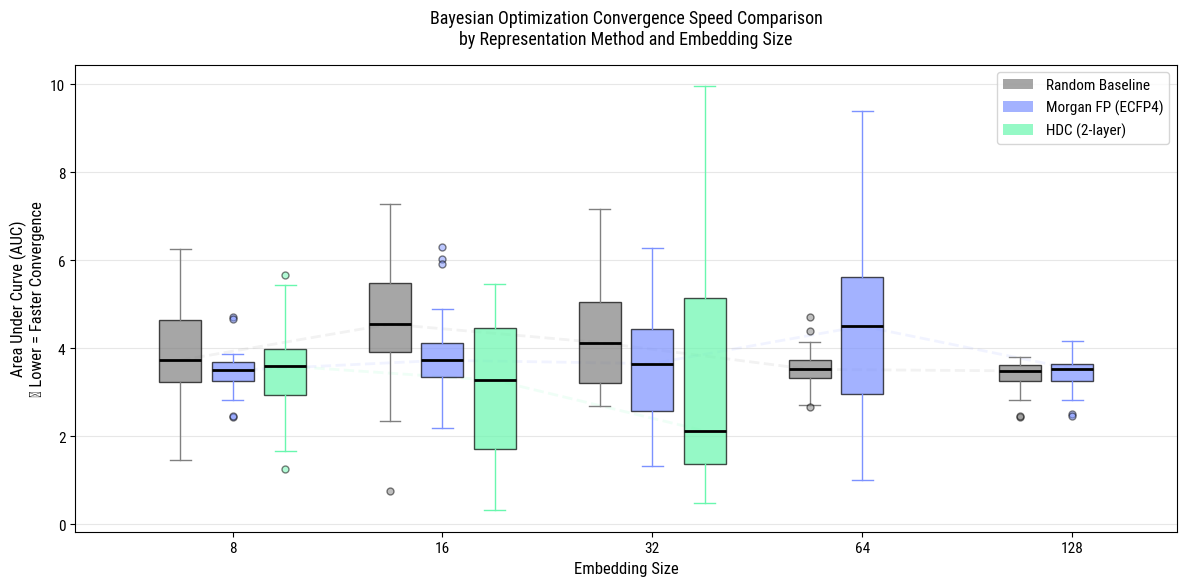

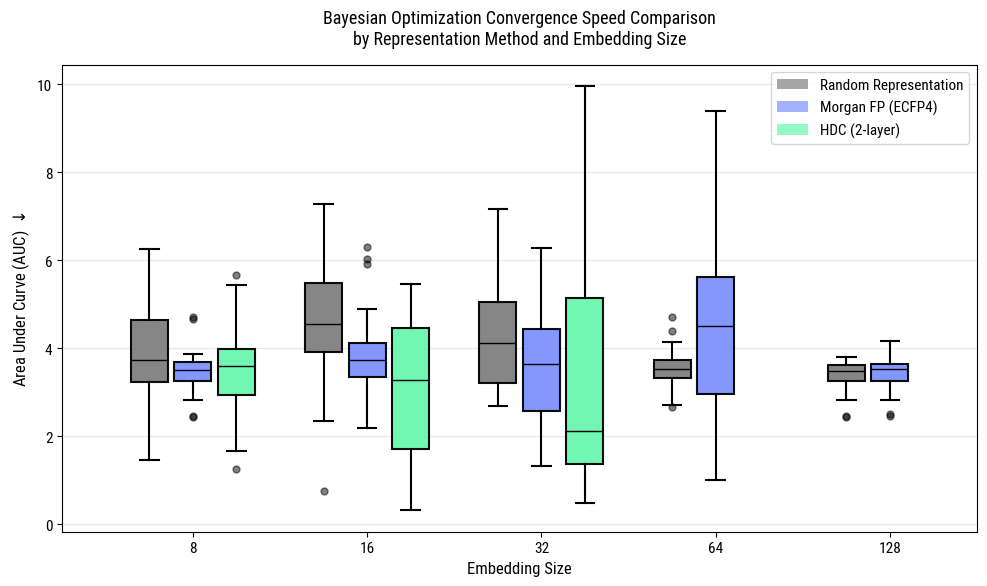

In [9]:
%matplotlib inline
# ============================================================================
# CONFIGURATION
# ============================================================================

# Embedding sizes to visualize (should match sweep in _slurm_ex_07.py)
EMBEDDING_SIZES = [8, 16, 32, 64, 128]

# Figure size (width, height) in inches
FIGSIZE = (10, 6)

# Font size
FONT_SIZE = 11

# Color scheme (matching other experiment analyses)
COLORS = {
    'random': '#808080',   # Gray for random baseline
    'fp': '#7C92FF',       # Blue for fingerprints (matching analyze_ex_03)
    'hdc': '#69F7AE',      # Green for HDC (matching analyze_ex_03)
}

# Labels for legend
LABELS = {
    'random': 'Random Representation',
    'fp': 'Morgan FP (ECFP4)',
    'hdc': 'HDC (2-layer)',
}


# ============================================================================
# PLOT SETUP
# ============================================================================

plt.style.use('default')
plt.rcParams['font.family'] = 'Roboto Condensed'
plt.rcParams['font.size'] = FONT_SIZE

fig, ax = plt.subplots(figsize=FIGSIZE)


# ============================================================================
# DATA PREPARATION FOR BOX PLOTS
# ============================================================================

# Organize data for box plots
# We want to create box plots at each embedding size, with three boxes side-by-side
# for random, fp, and hdc

encodings = ['random', 'fp', 'hdc']
box_width = 0.25  # Width of each box
positions_offset = [-box_width, 0, box_width]  # Offsets for side-by-side boxes

# For each embedding size, create box plots for each encoding
for size_idx, emb_size in enumerate(EMBEDDING_SIZES):
    
    for enc_idx, encoding in enumerate(encodings):
        key = (encoding, emb_size)
        
        if key in metrics_data and metrics_data[key]['auc']:
            auc_values = metrics_data[key]['auc']
            
            # Calculate position for this box
            # X position: size_idx gives the base position, offset moves it left/right
            position = size_idx + positions_offset[enc_idx]
            
            # Create box plot
            bp = ax.boxplot(
                [auc_values],
                positions=[position],
                widths=box_width * 0.85,
                patch_artist=True,
                showfliers=True,
                boxprops=dict(facecolor=COLORS[encoding], alpha=0.95, edgecolor='black', linewidth=1.5),
                medianprops=dict(color='black', linewidth=1.0),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='black', 
                              markersize=5, alpha=0.5),
            )


# ============================================================================
# AXIS CONFIGURATION
# ============================================================================

# Set x-axis labels to embedding sizes
ax.set_xticks(range(len(EMBEDDING_SIZES)))
ax.set_xticklabels(EMBEDDING_SIZES)
ax.set_xlabel('Embedding Size', fontsize=FONT_SIZE + 1)

# Set y-axis label
ax.set_ylabel('Area Under Curve (AUC) $\downarrow$', fontsize=FONT_SIZE + 1)

# Set title
ax.set_title('Bayesian Optimization Convergence Speed Comparison\nby Representation Method and Embedding Size',
             fontsize=FONT_SIZE + 2, pad=15)

# Add grid for readability
ax.grid(True, alpha=0.3, axis='y')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['random'], alpha=0.7, label=LABELS['random']),
    Patch(facecolor=COLORS['fp'], alpha=0.7, label=LABELS['fp']),
    Patch(facecolor=COLORS['hdc'], alpha=0.7, label=LABELS['hdc']),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Additional Visualization: Mean AUC Trends

Line plot showing mean AUC across embedding sizes for easier trend identification.

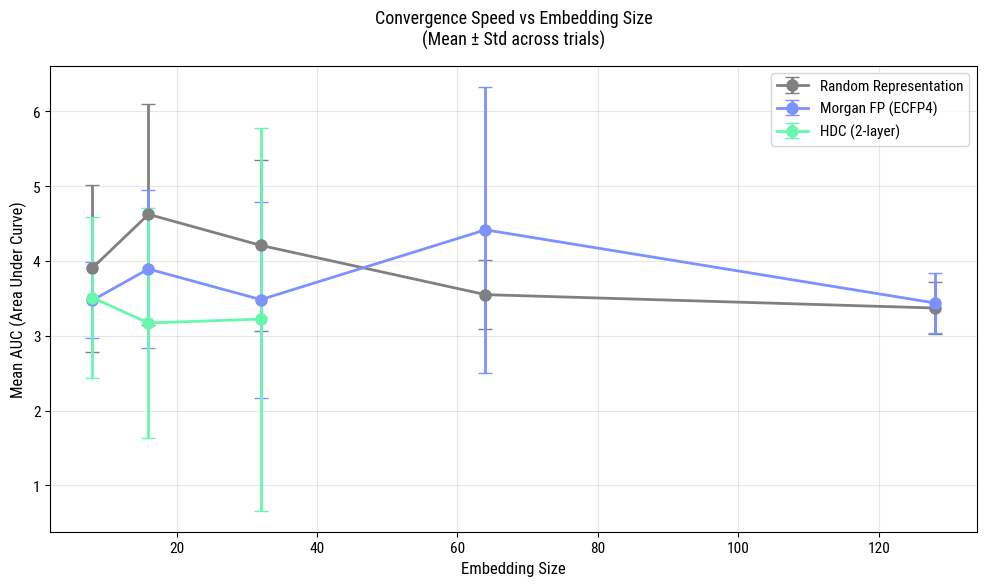


✅ Line plot visualization complete


In [10]:
%matplotlib inline
# ============================================================================
# LINE PLOT: MEAN AUC TRENDS
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

for encoding in encodings:
    means = []
    stds = []
    sizes_available = []
    
    for emb_size in EMBEDDING_SIZES:
        key = (encoding, emb_size)
        if key in metrics_data and metrics_data[key]['auc']:
            auc_values = metrics_data[key]['auc']
            means.append(np.mean(auc_values))
            stds.append(np.std(auc_values))
            sizes_available.append(emb_size)
    
    if means:
        means = np.array(means)
        stds = np.array(stds)
        sizes_available = np.array(sizes_available)
        
        # Plot line with error bars
        ax.errorbar(sizes_available, means, yerr=stds, 
                   fmt='o-', label=LABELS[encoding], 
                   color=COLORS[encoding], capsize=5, linewidth=2, markersize=8)

ax.set_xlabel('Embedding Size', fontsize=FONT_SIZE + 1)
ax.set_ylabel('Mean AUC (Area Under Curve)', fontsize=FONT_SIZE + 1)
ax.set_title('Convergence Speed vs Embedding Size\n(Mean ± Std across trials)',
             fontsize=FONT_SIZE + 2, pad=15)
ax.legend(fontsize=FONT_SIZE)
ax.grid(True, alpha=0.3)

# Optional: use log scale for x-axis if spanning multiple orders of magnitude
# ax.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n✅ Line plot visualization complete")

## Statistical Comparison

Perform statistical tests to quantify differences between representation methods.

In [11]:
from scipy import stats

print("\n" + "="*80)
print("STATISTICAL COMPARISON: HDC vs FP vs Random")
print("="*80)

# For each embedding size, compare the three methods
for emb_size in EMBEDDING_SIZES:
    print(f"\n\nEmbedding Size: {emb_size}")
    print("-" * 40)
    
    # Get AUC values for each method
    random_auc = metrics_data.get(('random', emb_size), {}).get('auc', [])
    fp_auc = metrics_data.get(('fp', emb_size), {}).get('auc', [])
    hdc_auc = metrics_data.get(('hdc', emb_size), {}).get('auc', [])
    
    if not (random_auc and fp_auc and hdc_auc):
        print("  ⚠️ Insufficient data for statistical comparison")
        continue
    
    # Print means
    print(f"  Random:  {np.mean(random_auc):.3f} ± {np.std(random_auc):.3f}")
    print(f"  FP:      {np.mean(fp_auc):.3f} ± {np.std(fp_auc):.3f}")
    print(f"  HDC:     {np.mean(hdc_auc):.3f} ± {np.std(hdc_auc):.3f}")
    
    # Perform pairwise t-tests
    print(f"\n  Pairwise t-tests (two-tailed):")
    
    # FP vs Random
    if len(fp_auc) > 1 and len(random_auc) > 1:
        t_stat, p_value = stats.ttest_ind(fp_auc, random_auc)
        improvement = (np.mean(random_auc) - np.mean(fp_auc)) / np.mean(random_auc) * 100
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"    FP vs Random:  p={p_value:.4f} {sig}  (FP {improvement:+.1f}% better)")
    
    # HDC vs Random
    if len(hdc_auc) > 1 and len(random_auc) > 1:
        t_stat, p_value = stats.ttest_ind(hdc_auc, random_auc)
        improvement = (np.mean(random_auc) - np.mean(hdc_auc)) / np.mean(random_auc) * 100
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"    HDC vs Random: p={p_value:.4f} {sig}  (HDC {improvement:+.1f}% better)")
    
    # HDC vs FP
    if len(hdc_auc) > 1 and len(fp_auc) > 1:
        t_stat, p_value = stats.ttest_ind(hdc_auc, fp_auc)
        improvement = (np.mean(fp_auc) - np.mean(hdc_auc)) / np.mean(fp_auc) * 100
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"    HDC vs FP:     p={p_value:.4f} {sig}  (HDC {improvement:+.1f}% better)")

print("\n\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("\n✅ Statistical analysis complete")


STATISTICAL COMPARISON: HDC vs FP vs Random


Embedding Size: 8
----------------------------------------
  Random:  3.904 ± 1.116
  FP:      3.474 ± 0.509
  HDC:     3.510 ± 1.076

  Pairwise t-tests (two-tailed):
    FP vs Random:  p=0.0919 ns  (FP +11.0% better)
    HDC vs Random: p=0.2187 ns  (HDC +10.1% better)
    HDC vs FP:     p=0.8818 ns  (HDC -1.0% better)


Embedding Size: 16
----------------------------------------
  Random:  4.623 ± 1.479
  FP:      3.893 ± 1.054
  HDC:     3.170 ± 1.535

  Pairwise t-tests (two-tailed):
    FP vs Random:  p=0.0547 ns  (FP +15.8% better)
    HDC vs Random: p=0.0016 **  (HDC +31.4% better)
    HDC vs FP:     p=0.0635 ns  (HDC +18.6% better)


Embedding Size: 32
----------------------------------------
  Random:  4.208 ± 1.139
  FP:      3.483 ± 1.309
  HDC:     3.223 ± 2.559

  Pairwise t-tests (two-tailed):
    FP vs Random:  p=0.0462 *  (FP +17.2% better)
    HDC vs Random: p=0.0914 ns  (HDC +23.4% better)
    HDC vs FP:     p=0.6597 ns  